 # 特征工程

 **学习目标**：创建一个包含极少特征但效果与更复杂的特征集一样出色的集合

 到目前为止，我们只在模型使用了单一特征。具有较少特征的模型会使用较少的资源，并且更易于维护。我们来看看能否构建这样一种模型：包含极少的住房特征，但效果与使用数据集中所有特征的模型一样出色。

 ## 特征表示

和之前一样，我们先加载并准备波士顿住房数据。

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.datasets import load_boston

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

boston_data = load_boston()
df_boston = pd.DataFrame(boston_data.data,columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
boston_housing_dataframe = df_boston

boston_housing_dataframe = boston_housing_dataframe.reindex(np.random.permutation(boston_housing_dataframe.index))

In [2]:
def preprocess_features(boston_housing_dataframe):
  return boston_housing_dataframe
  selected_features = boston_housing_dataframe[
    ["feature1",
     "feature2",
     "feature3"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["new_feature"] = (
    boston_housing_dataframe["feature1"] /
    boston_housing_dataframe["feature2"])
  return processed_features

def preprocess_targets(boston_housing_dataframe):
  output_targets = pd.DataFrame()
  output_targets["target"] = boston_housing_dataframe["target"]
  return output_targets

In [3]:
training_examples = preprocess_features(boston_housing_dataframe.head(350))
training_targets = preprocess_targets(boston_housing_dataframe.head(350))

validation_examples = preprocess_features(boston_housing_dataframe.tail(156))
validation_targets = preprocess_targets(boston_housing_dataframe.tail(156))


 ## 构建良好的特征集

**如果只使用 2 个或 3 个特征，可以获得的最佳效果是什么？**

**相关矩阵**展现了两两比较的相关性，既包括每个特征与目标特征之间的比较，也包括每个特征与其他特征之间的比较。

在这里，相关性被定义为[皮尔逊相关系数](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient)。相关性值具有以下含义：

  * `-1.0`：完全负相关
  * `0.0`：不相关
  * `1.0`：完全正相关

In [4]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["target"]

correlation_dataframe.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.0,-0.2,0.4,-0.1,0.4,-0.3,0.4,-0.4,0.7,0.6,0.3,-0.5,0.5,-0.4
ZN,-0.2,1.0,-0.5,-0.1,-0.5,0.3,-0.5,0.7,-0.3,-0.3,-0.4,0.2,-0.4,0.4
INDUS,0.4,-0.5,1.0,0.1,0.8,-0.4,0.6,-0.7,0.6,0.7,0.4,-0.3,0.6,-0.5
CHAS,-0.1,-0.1,0.1,1.0,0.1,0.1,0.1,-0.1,-0.0,-0.1,-0.1,0.0,-0.0,0.1
NOX,0.4,-0.5,0.8,0.1,1.0,-0.3,0.7,-0.8,0.6,0.7,0.2,-0.4,0.6,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TAX,0.6,-0.3,0.7,-0.1,0.7,-0.3,0.5,-0.5,0.9,1.0,0.5,-0.4,0.5,-0.5
PTRATIO,0.3,-0.4,0.4,-0.1,0.2,-0.4,0.2,-0.2,0.5,0.5,1.0,-0.2,0.4,-0.5
B,-0.5,0.2,-0.3,0.0,-0.4,0.2,-0.3,0.3,-0.5,-0.4,-0.2,1.0,-0.4,0.4
LSTAT,0.5,-0.4,0.6,-0.0,0.6,-0.7,0.6,-0.5,0.5,0.5,0.4,-0.4,1.0,-0.7


 理想情况下，我们希望具有与目标密切相关的特征。此外，我们还希望有一些相互之间的相关性不太密切的特征，以便它们添加独立信息。利用这些信息来尝试移除特征。也可以尝试构建其他合成特征，例如两个原始特征的比值。

In [5]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
      ds = ds.shuffle(10000)

    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
def train_model( learning_rate,  steps,  batch_size,  
                 training_examples,  training_targets,  validation_examples,  validation_targets):

  periods = 10
  steps_per_period = steps / periods
  #print(training_examples)
  #print(validation_examples)
  
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print( "Training model...")
  print( "RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print( "  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print( "Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, 'r:', label="training")
  plt.plot(validation_rmse, 'b-',label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 14.54
  period 01 : 14.43
  period 02 : 14.29
  period 03 : 14.16
  period 04 : 14.02
  period 05 : 13.89
  period 06 : 13.75
  period 07 : 13.62
  period 08 : 13.47
  period 09 : 13.33
Model training finished.


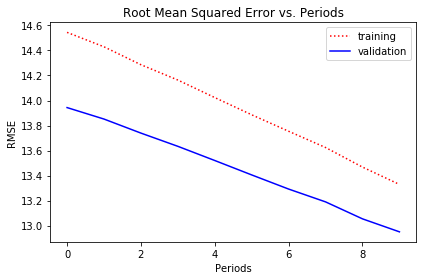

In [8]:
minimal_features = [
  "AGE"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=50,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 16.85
  period 01 : 15.00
  period 02 : 13.30
  period 03 : 11.63
  period 04 : 10.18
  period 05 : 8.76
  period 06 : 7.63
  period 07 : 6.77
  period 08 : 6.26
  period 09 : 6.11
Model training finished.


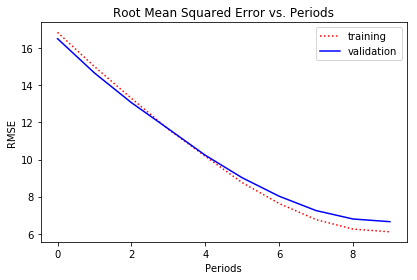

In [9]:
minimal_features = [
  "LSTAT",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=50,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ## 加入更多特征

Training model...
RMSE (on training data):
  period 00 : 8.43
  period 01 : 6.44
  period 02 : 5.83
  period 03 : 5.60
  period 04 : 5.56
  period 05 : 5.59
  period 06 : 5.54
  period 07 : 5.53
  period 08 : 5.56
  period 09 : 5.52
Model training finished.


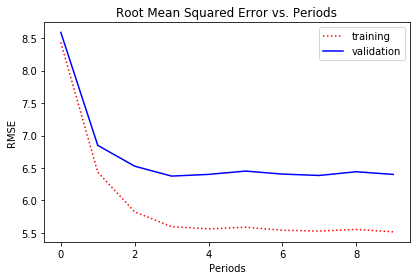

In [10]:
minimal_features = [
  "LSTAT","RM","AGE"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=50,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ## 特征组合

 **学习目标：**
  * 使用 FTRL 优化算法进行模型训练
  * 通过分箱和特征组合创建新的合成特征

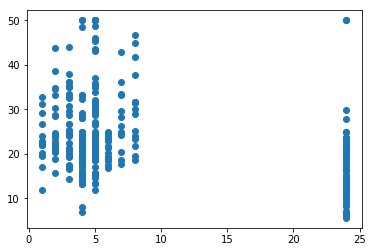

In [11]:
plt.scatter(training_examples["RAD"], training_targets["target"])

Training model...
RMSE (on training data):
  period 00 : 17.31
  period 01 : 14.75
  period 02 : 12.35
  period 03 : 10.55
  period 04 : 9.34
  period 05 : 8.74
  period 06 : 8.59
  period 07 : 8.35
  period 08 : 8.33
  period 09 : 8.33
Model training finished.


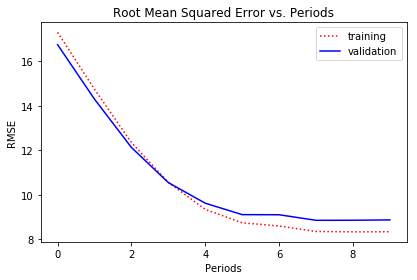

In [12]:
minimal_features = [
  "RAD"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=50,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 **尝试创建利用分箱的合成特征。**

我们可以将 RAD 空间分成 3 个不同的分箱（例如 `RAD_0_to_10`、`RAD_10_to_20` 等）：如果 `RAD` 位于相应分箱范围内，则显示值 `1.0`；如果不在范围内，则显示值 `0.0`。可以使用相关矩阵来指导构建合成特征；如果发现效果还不错的合成特征，可以将其添加到模型中。

In [13]:
for r in zip(range(0, 25,10), range(10, 35,10)):
    print (r)

(0, 10)
(10, 20)
(20, 30)


In [14]:
def select_and_transform_features(source_df):
  THREE_RANGES = zip(range(0, 25,10), range(10, 35,10))
  selected_examples = pd.DataFrame()

  for r in THREE_RANGES:
    selected_examples["RAD_%d_to_%d" % r] = source_df["RAD"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Training model...
RMSE (on training data):
  period 00 : 13.10
  period 01 : 8.25
  period 02 : 8.26
  period 03 : 8.26
  period 04 : 8.26
  period 05 : 8.25
  period 06 : 8.25
  period 07 : 8.25
  period 08 : 8.25
  period 09 : 8.25
Model training finished.


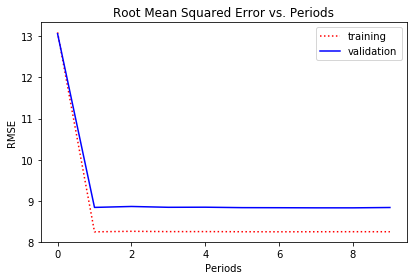

In [15]:
_ = train_model(
    learning_rate=0.01,
    steps=2000,
    batch_size=50,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

 ### FTRL 优化算法

高维度线性模型可受益于使用一种基于梯度的优化方法，叫做 FTRL。该算法的优势是针对不同系数以不同方式调整学习速率，如果某些特征很少采用非零值，该算法可能比较实用（也非常适合支持 L1 正则化）。我们可以使用 [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer) 来应用 FTRL。

In [16]:
def train_model(learning_rate, steps, batch_size, feature_columns,
                training_examples,training_targets,validation_examples,validation_targets):

  periods = 10
  steps_per_period = steps / periods

  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print ("Training model...")
  print ("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print ("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print ("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 22.87
  period 01 : 13.81
  period 02 : 10.48
  period 03 : 11.46
  period 04 : 9.90
  period 05 : 9.96
  period 06 : 9.76
  period 07 : 9.05
  period 08 : 9.13
  period 09 : 8.83
Model training finished.


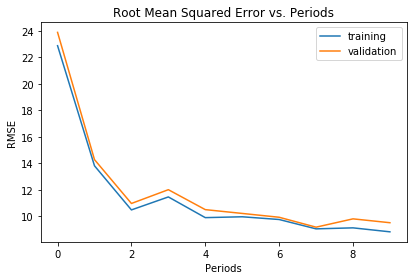

In [17]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=50,
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 分箱特征
要为分箱特征定义特征列，我们可以使用 [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column)（而不是使用 `numeric_column`），该列将数字列作为输入，并使用 `boundardies` 参数中指定的分箱边界将其转换为分箱特征。以下代码为 `households` 和 `longitude` 定义了分箱特征列；`get_quantile_based_boundaries` 函数会根据分位数计算边界，以便每个分箱包含相同数量的元素。

In [18]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

# Divide households into 3 buckets.
rad = tf.feature_column.numeric_column("RAD")
bucketized_rad = tf.feature_column.bucketized_column(
  rad, boundaries=get_quantile_based_boundaries(
    boston_housing_dataframe["RAD"], 3))

In [19]:
def construct_feature_columns():

  rm = tf.feature_column.numeric_column("RM")
  rad = tf.feature_column.numeric_column("RAD")
  age = tf.feature_column.numeric_column("AGE")
  
  bucketized_rm = tf.feature_column.bucketized_column(
    rm, boundaries=get_quantile_based_boundaries(
      training_examples["RM"], 7))

  bucketized_rad = tf.feature_column.bucketized_column(
    rad, boundaries=get_quantile_based_boundaries(
      training_examples["RAD"], 3))
  
  bucketized_age = tf.feature_column.bucketized_column(
    age, boundaries=get_quantile_based_boundaries(
      training_examples["AGE"], 10))

  
  feature_columns = set([
    bucketized_rm,
    bucketized_rad,
    bucketized_age,
  ])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 5.51
  period 01 : 5.42
  period 02 : 5.36
  period 03 : 5.41
  period 04 : 5.39
  period 05 : 5.39
  period 06 : 5.39
  period 07 : 5.36
  period 08 : 5.37
  period 09 : 5.36
Model training finished.


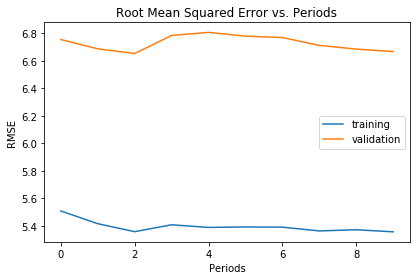

In [20]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=50,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### 特征组合

组合两个（或更多个）特征是使用线性模型来学习非线性关系的一种聪明做法。目前，特征列 API 仅支持组合离散特征。要组合两个连续的值（比如 `RM` 或 `RAD`），我们可以对其进行分桶。

如果我们组合 `RM` 和 `RAD` 特征（例如，假设 `RM` 被分到 `7` 个分桶中，而 `RAD` 有 `3` 个分桶），我们实际上会得到 21 个组合的二元特征。当我们训练模型时，每个特征都会分别获得自己的权重。

In [21]:
def construct_feature_columns():

  rm = tf.feature_column.numeric_column("RM")
  rad = tf.feature_column.numeric_column("RAD")
  age = tf.feature_column.numeric_column("AGE")

  bucketized_rm = tf.feature_column.bucketized_column(
    rm, boundaries=get_quantile_based_boundaries(
      training_examples["RM"], 7))

  bucketized_rad = tf.feature_column.bucketized_column(
    rad, boundaries=get_quantile_based_boundaries(
      training_examples["RAD"], 3))
  
  bucketized_age = tf.feature_column.bucketized_column(
    age, boundaries=get_quantile_based_boundaries(
      training_examples["AGE"], 10))
  

  rm_x_rad = tf.feature_column.crossed_column(
  set([bucketized_rm, bucketized_rad]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_rm,
    bucketized_rad,
    bucketized_age,
    rm_x_rad
  ])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 5.22
  period 01 : 5.10
  period 02 : 5.13
  period 03 : 5.09
  period 04 : 5.11
  period 05 : 5.11
  period 06 : 5.10
  period 07 : 5.09
  period 08 : 5.07
  period 09 : 5.09
Model training finished.


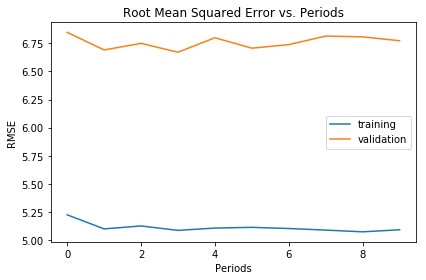

In [22]:
_ = train_model(
    learning_rate=1.0,
    steps=500,
    batch_size=100,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)